# B(N)PO :: 3rd iteration of wheeler project for Reacher UnityML environment
---

### 1. Import the Necessary Packages

In [1]:
import torch
from alchemy.agent import Agent, BrainDescription
from alchemy.env import Env

import model

import matplotlib.pyplot as plt
%matplotlib inline

### 2. Load CONFIG :: TODO -> more implicit config

In [2]:
TOTAL_ENV = 20
GOAL_SIZE = 3
STATE_SIZE = 33 - GOAL_SIZE
ACTION_SIZE = 4
N_STEP = 10

N_HISTORY = 1#4#
N_ACTORS = 1
MAX_STEPS = 70

DEVICE = "cpu"

### 3. Load Environment

In [3]:
from tasks.uml_reacher_moving_mrocs import StaticReacherProxy, N_REWARDS, f_reward
from utils.task import Task

task = Task(StaticReacherProxy, 30.)

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_speed -> 1.0
		goal_size -> 5.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


### 4. Encoders

In [4]:
from utils.encoders import *
from utils.rnn import FasterGRUEncoder

def Encoder():
    return GlobalNormalizer(STATE_SIZE, N_HISTORY)
    return StackedEncoder(
            GlobalNormalizer(STATE_SIZE, N_HISTORY),
            FasterGRUEncoder(STATE_SIZE, N_HISTORY, 2 * 48, 2))

def GoalEncoder():
    return GoalGlobalNorm(GOAL_SIZE)

encoder = Encoder()
encoder.share_memory()
goal_encoder = GoalEncoder()
goal_encoder.share_memory()

GoalGlobalNorm(
  (norm): Normalizer()
)

### 4. Actor + Critic models

In [5]:
def Actor(encoder, action_size):
    nes_layers = [encoder.out_size() + GOAL_SIZE, 400, 300, action_size]
    return lambda: model.ActorFactory(
        nes_layers, action_size=action_size, 
        f_mean_clip=lambda x: x, f_scale_clip=torch.tanh,
        device=DEVICE)

def Critic(encoder, action_size, n_rewards):
    return lambda: model.Critic(N_ACTORS, n_rewards, encoder.out_size(), action_size)

### 5. Debug out callback, post priting graph + meassuring time

In [6]:
from timebudget import timebudget
try:
    timebudget.set_quiet()
except:
    pass
import time
env_start = time.time()
env_counter = 0
def callback(bot, task, test_scores, learn_scores, seeds, total):
    global env_start, env_counter
    env_counter += 1
    if test_scores is None:
        return
    print("\n\t [", env_counter, "] < %.2f"%(time.time()-env_start), "sec > TEST ==> ", test_scores, "exploring score:", learn_scores.mean())
    timebudget.report("_clocked_step")

### 6. HER implementation ~ buffer specialization

In [7]:
from utils.her import HER, CreditAssignment

import random
class ReacherHER(HER):
    def update_goal(self, rewards, goals, states, states_1, n_goals, n_states, actions, her_step_inds, n_steps):
        MAX_HER_STEP = 1
        gid = 0
        delta = 0
        h_rewards = rewards.clone()
        h_goals = goals.clone()
        h_n_goals = n_goals.clone()
        for i, (g, s, n_g, n, u, step) in enumerate(zip(goals, states, n_goals, n_states, her_step_inds, n_steps)):
            her_active = bool(sum(her_step_inds[(i-MAX_HER_STEP) if MAX_HER_STEP < i else 0:i]))

            if not her_active and u: # we will set-up new goal
                gid = random.randint(0, len(goals[:-self.n_step-MAX_HER_STEP])-1)
                delta = 0

            if her_active or u:
                if gid+delta+self.n_step<len(goals) and i<len(goals)-self.n_step:# previous state was assigned HER
                    g, n_g = goals[gid+delta], goals[gid+delta+step]
                delta += 1

            h_rewards[i] = torch.tensor(f_reward(s, n, g, None, True, None, None))
            h_goals[i] = g.clone()
            h_n_goals[i] = n_g.clone()
        return ( h_rewards, h_goals, states, h_n_goals, n_states )

def ReacherCreditAssignment(cind, gae, n_step, floating_step, gamma, gae_tau, her_delay):
    print("HER IS TURNED OFF!!")
    return CreditAssignment(cind=cind, gae=gae, n_step=n_step, floating_step=floating_step, gamma=gamma, gae_tau=gae_tau)

### 7. Setup agent ( memory + credit assignment + environment and algorithm ~ actor-critic )

In [8]:
from utils.memory import Memory
from utils.memlocal import MemoryBoost

def new_agent(
    her, brains, 
    goal_encoder, encoder, freeze_delta, freeze_count, 
    action_size, n_rewards, n_step, max_steps,
    detach_actors, detach_critics, stable_probs,
    good_reach=1, model_path="checkpoints", save=False, load=False,
    eval_delay=20
    ):
        
    credit_assign = [ ReacherHER(
        cind=i, gae=True, n_step=n_step, floating_step=True, gamma=.99, gae_tau=.95, her_delay=h) if h else ReacherCreditAssignment(
        cind=i, gae=True, n_step=n_step, floating_step=True, gamma=.99, gae_tau=.95, her_delay=None) for i, h in enumerate(her) ]

    # g, s, f, a, p, r, n_g, n_s, n_f, c, d
    memory = Memory(20 * max_steps * 200, recalc_delay=5, chunks=[
        GOAL_SIZE, STATE_SIZE, encoder.features_n(), 3*action_size, action_size, 
        n_rewards, GOAL_SIZE, STATE_SIZE, encoder.features_n(), n_rewards, 1], 
                    ep_draw=10, device=DEVICE)

    experience = lambda descs, brain: MemoryBoost(descs, memory, credit_assign, brain, n_step, good_reach)

    agent = Agent(
        DEVICE,
        brains, experience,
        Actor=Actor(encoder, action_size), Critic=Critic(encoder, action_size, n_rewards), 
        goal_encoder=goal_encoder, encoder=encoder, 
        n_agents=1, detach_actors=detach_actors, detach_critics=detach_critics, stable_probs=stable_probs,
        resample_delay=10, min_step=n_step*2,
        state_size=STATE_SIZE, action_size=action_size,
        freeze_delta=freeze_delta, freeze_count=freeze_count,
        lr_critic=5e-5, clip_norm=1.,
        model_path=model_path, save=save, load=load, delay=10
    )

    # defined above
    env = Env(agent, 
            total_envs=TOTAL_ENV, n_history=N_HISTORY, history_features=encoder.features_n(), state_size=encoder.in_size(),
            n_step=n_step, send_delta=max_steps,
            eval_limit=10, eval_ratio=.5, max_n_episode=max_steps, eval_delay=eval_delay,
            mcts_random_cap=100000, mcts_rounds=1, mcts_random_ratio=10, limit=2000)
    
    return agent, env

## 8. in depth setup of ALGORITHMs used ( bpo ~> ppo / ddpg / natural )

In [9]:
BS = 2048

bpo_brain = [
    
        BrainDescription( # master :: PPO
            memory_size=20 * MAX_STEPS * 10, batch_size=1024, 
            
            optim_pool_size=(MAX_STEPS * 40 * 6 * 6 * 1) // 3,
            optim_epochs=1, optim_batch_size=1*BS, recalc_delay=2,
            
            lr_actor=1e-4, learning_delay=1*N_STEP, learning_repeat=6,

            sync_delta_a=1, sync_delta_c=1, tau_actor=1e-1, tau_critic=0,
            bellman=False, ppo_eps=2e-1, natural=False, mean_only=False, separate_actors=False),
    
        BrainDescription( # master :: PPO
            memory_size=20 * MAX_STEPS * 6, batch_size=BS, 
            
            optim_pool_size=(MAX_STEPS * 80 * 20) // 3,
            optim_epochs=1, optim_batch_size=1*BS, recalc_delay=2,
            
            lr_actor=1e-4, learning_delay=3*MAX_STEPS, learning_repeat=20, # train here more will do also job!
            sync_delta_a=1, sync_delta_c=1, tau_actor=1, tau_critic=1,
            bellman=False, ppo_eps=2e-1, natural=False, mean_only=False, separate_actors=False),

]
print("\nB(N)PO: \n", [b for b in bpo_brain])


B(N)PO: 
 [[14000, '<- memory_size;', 1024, '<- batch_size;', 1, '<- optim_epochs;', 2048, '<- optim_batch_size;', 33600, '<- optim_pool_size;', 2, '<- recalc_delay;', 1, '<- sync_delta_a;', 1, '<- sync_delta_c;', 10, '<- learning_delay;', 6, '<- learning_repeat;', 0.0001, '<- lr_actor;', 0.1, '<- tau_actor;', 0, '<- tau_critic;', 0.2, '<- ppo_eps;', False, '<- natural;', False, '<- mean_only;'], [8400, '<- memory_size;', 2048, '<- batch_size;', 1, '<- optim_epochs;', 2048, '<- optim_batch_size;', 37333, '<- optim_pool_size;', 2, '<- recalc_delay;', 1, '<- sync_delta_a;', 1, '<- sync_delta_c;', 210, '<- learning_delay;', 20, '<- learning_repeat;', 0.0001, '<- lr_actor;', 1, '<- tau_actor;', 1, '<- tau_critic;', 0.2, '<- ppo_eps;', False, '<- natural;', False, '<- mean_only;']]


## 9. LEARN!

HER IS TURNED OFF!!
HER IS TURNED OFF!!


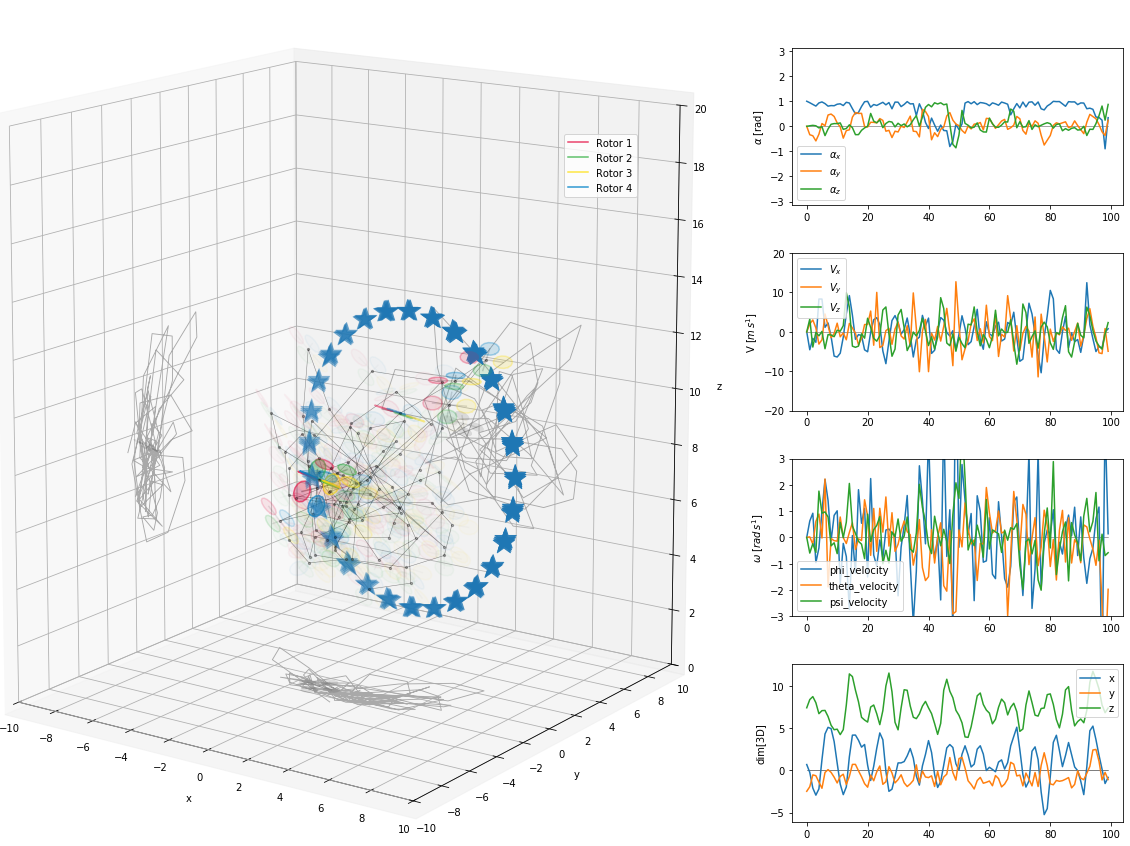

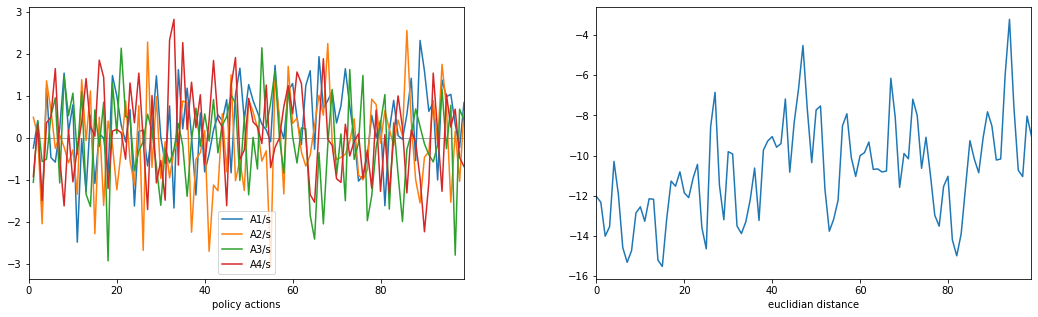

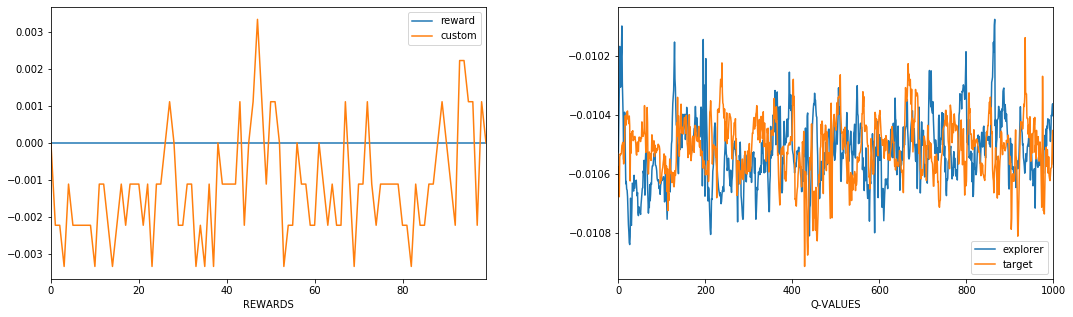

[   19>  1329:: 0] steps =   69, max_step =  70/ 70, reward=-0.006278 <action=tensor([-1.7231,  0.8248, -0.4899, -0.1195])>                                    
	 [ 19 ] < 501.67 sec > TEST ==>  [[tensor(0.8665)], [tensor(0.7580)]] exploring score: tensor(-0.0068)
timebudget report per _clocked_step cycle...
            _clocked_step: 100.0%   333.94ms/cyc @     1.0 calls/cyc
              learn-round: 100.0%   333.89ms/cyc @     0.6 calls/cyc
                    learn: 100.0%   333.87ms/cyc @     0.6 calls/cyc
        FullMemory-sample:  80.5%   268.95ms/cyc @     0.2 calls/cyc
            _push_to_fast:  65.5%   218.89ms/cyc @    53.0 calls/cyc
                 __call__:  33.1%   110.43ms/cyc @    53.3 calls/cyc
                   _learn:  25.6%    85.33ms/cyc @     0.6 calls/cyc
        FastMemory-sample:  19.4%    64.89ms/cyc @     0.4 calls/cyc
                 backprop:  12.7%    42.47ms/cyc @     1.3 calls/cyc
             recalc_feats:   0.9%     3.00ms/cyc @     9.0 calls/cyc
 

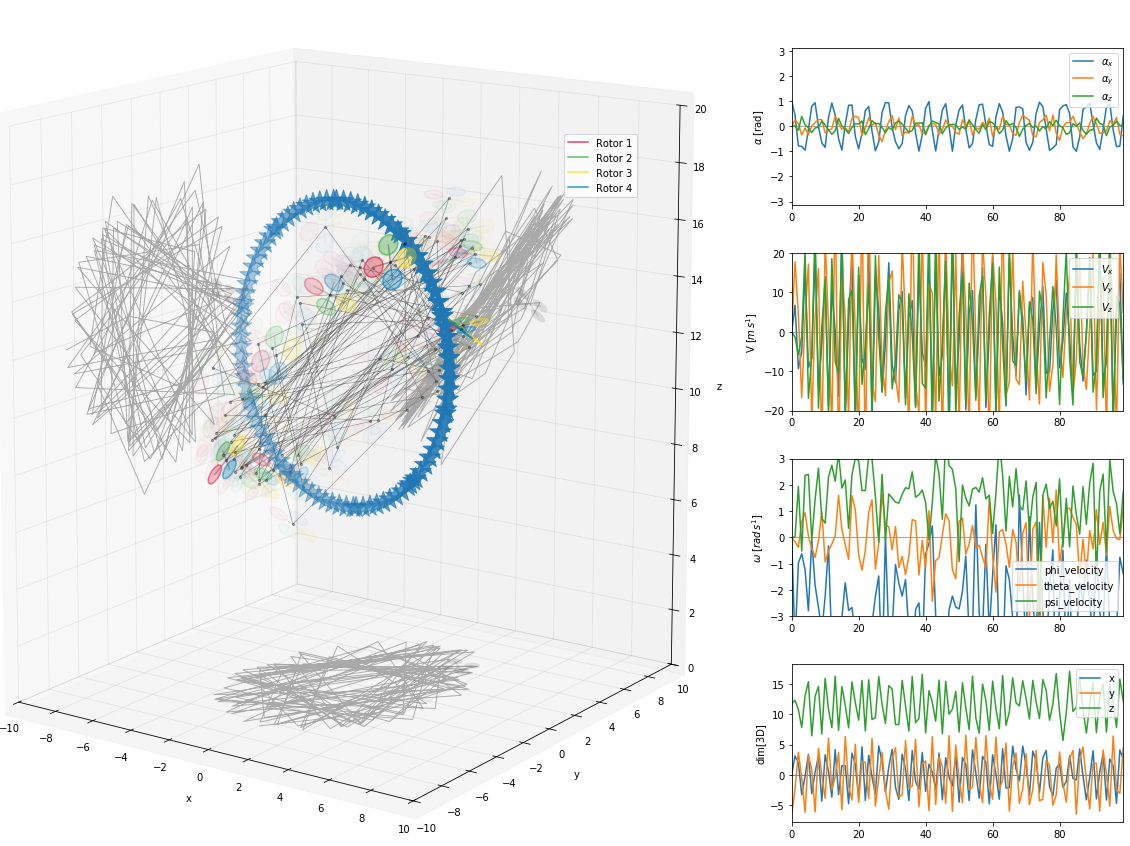

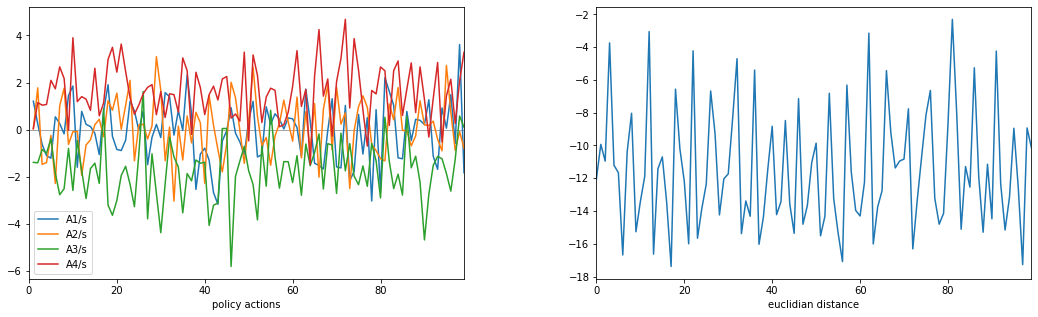

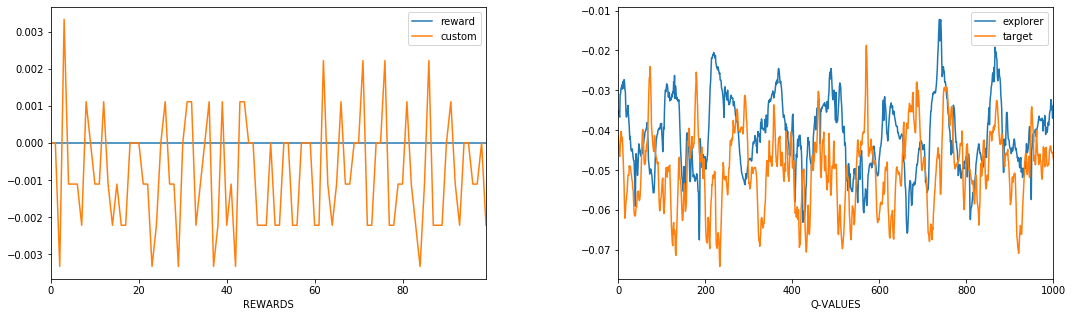

[   27>  1859:: 0] steps =   39, max_step =  70/ 70, reward=-0.015444 <action=tensor([ 2.3143,  6.3554,  5.7403, -0.6566])>                                    PPO too off, from sampled actions, policies problems!!  20 1008 tensor(-8.6441, grad_fn=<MeanBackward0>) tensor(-1.4321)
[   27>  1889:: 0] steps =   69, max_step =  70/ 70, reward=-0.041833 <action=tensor([ 2.4693,  7.4097,  1.1164, -0.2556])>                    PPO too off, from sampled actions, policies problems!!  40 1008 tensor(-8.3911, grad_fn=<MeanBackward0>) tensor(-1.4176)
PPO too off, from sampled actions, policies problems!!  20 160 tensor(-5.7234, grad_fn=<MeanBackward0>) tensor(-1.4515)
[   28>  1919:: 0] steps =   29, max_step =  70/ 70, reward=-0.023778 <action=tensor([3.4220, 7.4851, 5.1802, 0.1126])>                                        PPO too off, from sampled actions, policies problems!!  60 1008 tensor(-9.4003, grad_fn=<MeanBackward0>) tensor(-1.4429)
[   28>  1959:: 0] steps =   69, max_step =  70/ 70, rew

[   79>  5529:: 0] steps =   69, max_step =  70/ 70, reward=-0.000833 <action=tensor([-1.5162, -2.2078, -3.0496,  0.0817])>                                    
	 [ 79 ] < 2326.50 sec > TEST ==>  [[tensor(2.0780)], [tensor(1.3935)]] exploring score: tensor(-0.0009)
timebudget report per _clocked_step cycle...
            _clocked_step: 100.0%   378.57ms/cyc @     1.0 calls/cyc
              learn-round: 100.0%   378.51ms/cyc @     0.7 calls/cyc
                    learn: 100.0%   378.48ms/cyc @     0.7 calls/cyc
        FullMemory-sample:  80.9%   306.24ms/cyc @     0.2 calls/cyc
            _push_to_fast:  66.1%   250.08ms/cyc @    57.0 calls/cyc
                 __call__:  33.3%   126.08ms/cyc @    57.3 calls/cyc
                   _learn:  24.8%    94.07ms/cyc @     0.7 calls/cyc
        FastMemory-sample:  19.1%    72.20ms/cyc @     0.4 calls/cyc
                 backprop:  12.4%    46.88ms/cyc @     1.4 calls/cyc
                    _push:   2.4%     9.11ms/cyc @     0.3 calls/cyc


[  239> 16729:: 0] steps =   69, max_step =  70/ 70, reward=0.121444 <action=tensor([-0.4223,  0.0747,  0.5024,  1.1315])>                                     
	 [ 239 ] < 7410.78 sec > TEST ==>  [[tensor(20.3225)], [tensor(21.7420)]] exploring score: tensor(0.1239)
timebudget report per _clocked_step cycle...
            _clocked_step: 100.0%   386.84ms/cyc @     1.0 calls/cyc
              learn-round: 100.0%   386.78ms/cyc @     0.7 calls/cyc
                    learn: 100.0%   386.76ms/cyc @     0.7 calls/cyc
        FullMemory-sample:  80.9%   312.90ms/cyc @     0.2 calls/cyc
            _push_to_fast:  66.1%   255.83ms/cyc @    57.4 calls/cyc
                 __call__:  33.3%   128.73ms/cyc @    57.7 calls/cyc
                   _learn:  24.8%    95.78ms/cyc @     0.7 calls/cyc
        FastMemory-sample:  19.1%    73.82ms/cyc @     0.5 calls/cyc
                 backprop:  12.3%    47.73ms/cyc @     1.4 calls/cyc
                    _push:   6.4%    24.88ms/cyc @     0.3 calls/cy

[  399> 27929:: 0] steps =   69, max_step =  70/ 70, reward=0.147389 <action=tensor([ 0.4721, -0.7711, -1.5132,  0.3981])>                                     
	 [ 399 ] < 12529.11 sec > TEST ==>  [[tensor(27.7325)], [tensor(28.9000)]] exploring score: tensor(0.1503)
timebudget report per _clocked_step cycle...
            _clocked_step: 100.0%   387.68ms/cyc @     1.0 calls/cyc
              learn-round: 100.0%   387.62ms/cyc @     0.7 calls/cyc
                    learn: 100.0%   387.60ms/cyc @     0.7 calls/cyc
        FullMemory-sample:  80.8%   313.30ms/cyc @     0.2 calls/cyc
            _push_to_fast:  66.1%   256.26ms/cyc @    57.3 calls/cyc
                 __call__:  33.2%   128.77ms/cyc @    57.6 calls/cyc
                   _learn:  24.8%    96.18ms/cyc @     0.7 calls/cyc
        FastMemory-sample:  19.2%    74.26ms/cyc @     0.5 calls/cyc
                 backprop:  12.4%    47.93ms/cyc @     1.4 calls/cyc
                    _push:   7.8%    30.16ms/cyc @     0.3 calls/c

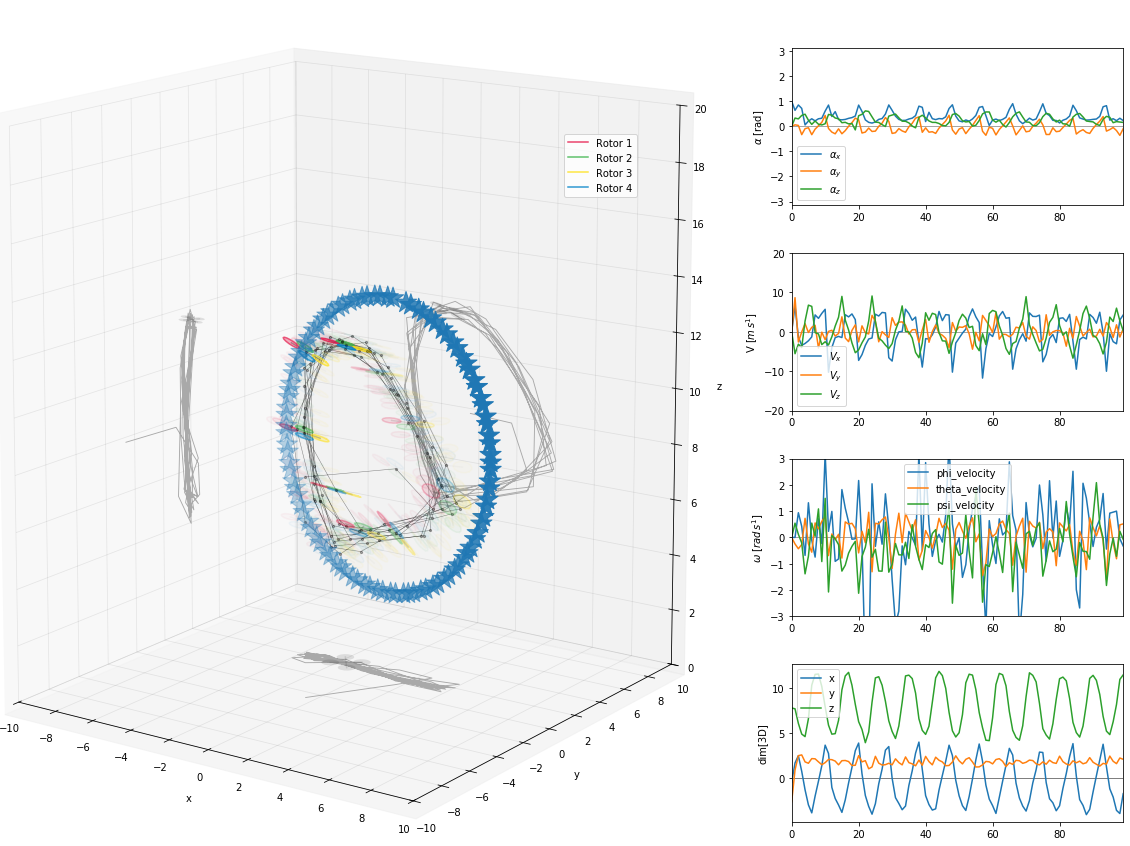

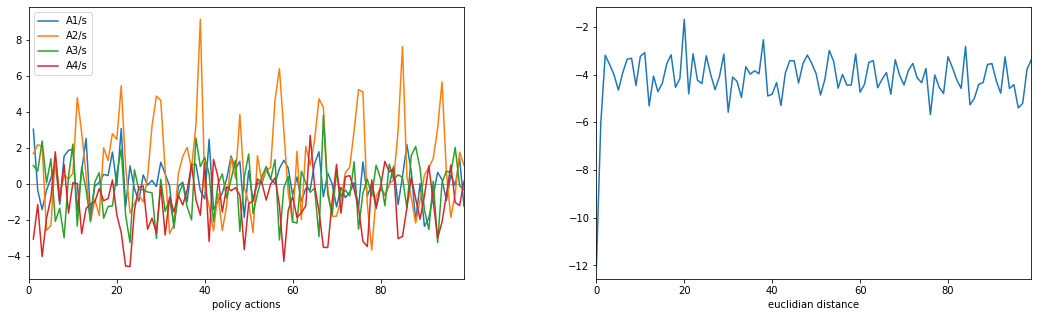

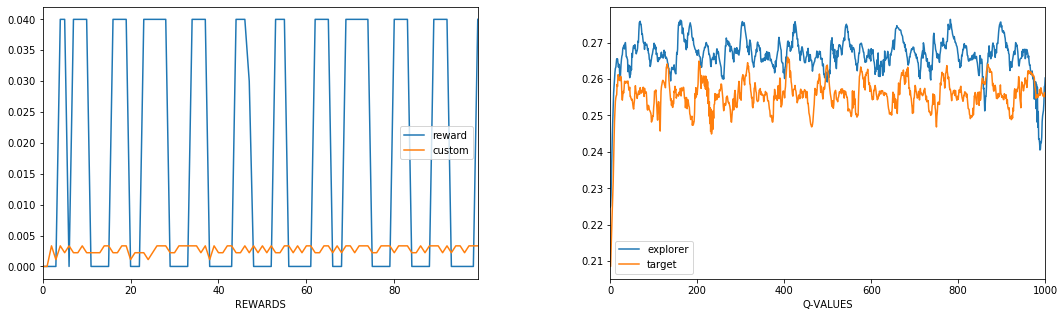

[  539> 37729:: 0] steps =   69, max_step =  70/ 70, reward=0.157111 <action=tensor([-0.2602, -0.4581,  0.5379, -0.5973])>                                    
 environment solved!  29.857074332642362 [array([30.72469931, 28.98944935])]
[[tensor(31.1180), tensor(29.9860), tensor(30.0775), tensor(29.3795), tensor(30.7735), tensor(33.3705), tensor(30.6010), tensor(29.7215), tensor(30.9810), tensor(31.2385)], [tensor(28.5750), tensor(30.0050), tensor(29.5025), tensor(27.6720), tensor(28.5880), tensor(30.0485), tensor(30.1310), tensor(28.9440), tensor(29.0700), tensor(27.3585)]]


In [10]:
agent, env = new_agent(
    [0, 0], bpo_brain, 
    goal_encoder, encoder, freeze_delta=3, freeze_count=3, 
    action_size=4, n_rewards=N_REWARDS, n_step=N_STEP, max_steps=MAX_STEPS,
    detach_actors=True, detach_critics=False, stable_probs=False,
    good_reach=1, model_path="checkpoints", save=True, load=False
    )
scores = env.start(task, callback)

In [11]:
losses = agent.brain.losses
scores_ex = scores[1:]
scores = np.asarray(scores_ex).flatten()
losses_ex = losses
losses = np.vstack(losses_ex)[::len(losses_ex)//200]

### 10. Plot training reward + loss

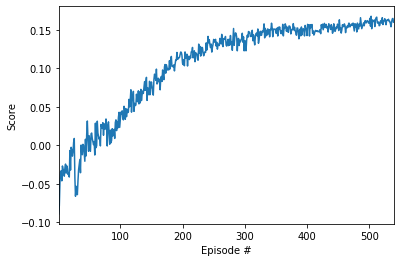

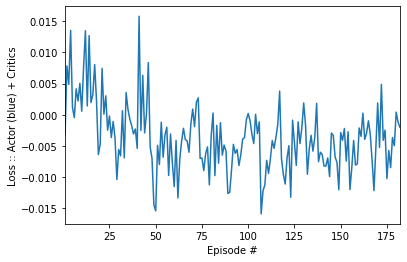

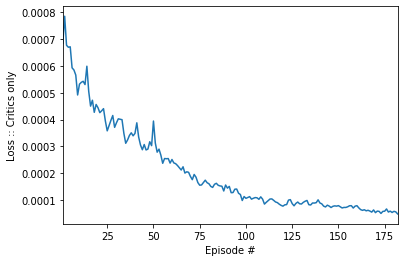

In [12]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show() 

fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(losses) - len(losses) // 10+1), losses[len(losses) // 10:, 0])
plt.ylabel('Loss :: Actor (blue) + Critics')
plt.xlabel('Episode #')
plt.show() 

fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(losses) - len(losses) // 10+1), losses[len(losses) // 10:, 1:])
plt.ylabel('Loss :: Critics only')
plt.xlabel('Episode #')
plt.show() 

### 11. Reload trained agent

In [13]:
agent.sync_target(0, [])
agent.sync_explorer(0, [])

### 12. Test visuals - TARGET


 environment solved!  29.6086493381951 [array([30.26289932, 28.95439935])]
[[tensor(30.7615), tensor(32.9260), tensor(30.3015), tensor(30.4180), tensor(31.2935), tensor(27.5220), tensor(29.0635), tensor(30.1460), tensor(30.2830), tensor(29.9140)], [tensor(29.4795), tensor(29.9785), tensor(26.1720), tensor(30.2230), tensor(29.6585), tensor(28.9105), tensor(27.2925), tensor(29.2015), tensor(29.8690), tensor(28.7590)]]

 environment solved!  29.67894933662377 [array([30.58379932, 28.77409936])]
[[tensor(30.0480), tensor(31.1840), tensor(31.2925), tensor(30.7430), tensor(29.9815), tensor(28.7795), tensor(28.4660), tensor(32.6985), tensor(30.7095), tensor(31.9355)], [tensor(29.6480), tensor(27.4295), tensor(26.7095), tensor(27.5645), tensor(28.8835), tensor(30.8535), tensor(27.6820), tensor(30.3400), tensor(28.2565), tensor(30.3740)]]
mean rewards :  29.246638235175563 [29.67171693 28.82155954]


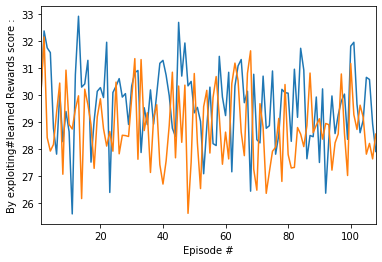

In [14]:
rewards = [[], []]
while len(rewards[0]) < 100:
    success, scores = env.evaluate(task)
    [ rewards[i].extend(score) for i, score in enumerate(scores) ]
        
print("mean rewards : ", np.mean(rewards), np.mean(rewards, 1))
fig = plt.figure()
ax = fig.add_subplot(111)
for r in rewards:
    plt.plot(np.arange(1, len(r)+1), r)
plt.ylabel('By exploiting#learned Rewards score :')
plt.xlabel('Episode #')
plt.show()

### 13. Test visuals - EXPLORER


 environment solved!  30.590649316245685 [array([30.18044933, 31.00084931])]
[[tensor(31.1745), tensor(30.4780), tensor(28.4795), tensor(27.6110), tensor(31.1530), tensor(31.4210), tensor(31.5155), tensor(31.9990), tensor(28.5490), tensor(29.4240)], [tensor(31.5160), tensor(32.0745), tensor(29.4155), tensor(30.0060), tensor(29.9330), tensor(31.5470), tensor(31.5380), tensor(32.4820), tensor(31.3100), tensor(30.1865)]]

 environment solved!  30.079099327679717 [array([29.71294934, 30.44524932])]
[[tensor(30.0080), tensor(31.0825), tensor(29.3675), tensor(31.8985), tensor(30.5605), tensor(29.4555), tensor(28.9130), tensor(28.0045), tensor(28.1610), tensor(29.6785)], [tensor(29.5085), tensor(30.6885), tensor(31.2015), tensor(28.3830), tensor(31.3885), tensor(31.6920), tensor(29.1955), tensor(31.2655), tensor(30.8205), tensor(30.3090)]]

 environment solved!  30.120324326758258 [array([30.31944932, 29.92119933])]
[[tensor(30.1775), tensor(31.3575), tensor(31.0660), tensor(30.2105), tensor

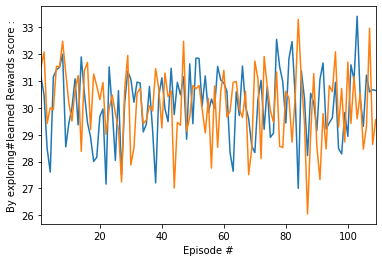

In [15]:
# for evaluation we will set target network to be explorer
agent.brain.ac_target = agent.brain.ac_explorer

rewards = [[], []]
while len(rewards[0]) < 100:
    success, scores = env.evaluate(task)
    [ rewards[i].extend(score) for i, score in enumerate(scores) ]
        
print("mean rewards : ", np.mean(rewards), np.mean(rewards, 1))
fig = plt.figure()
ax = fig.add_subplot(111)
for r in rewards:
    plt.plot(np.arange(1, len(r)+1), r)
plt.ylabel('By exploring#learned Rewards score :')
plt.xlabel('Episode #')
plt.show()